<a href="https://colab.research.google.com/github/rezaserajian/Homework3part1/blob/main/CS206D_Forgettability_Shap_Research_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ucimlrepo

# 1.0 Import Data

Dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE



In [31]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
wine_quality = fetch_ucirepo(id=186)

# Features and target
X_raw = wine_quality.data.features
y_raw = wine_quality.data.targets


# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [32]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
wine_quality = fetch_ucirepo(id=186)

# Features and target
X_raw = wine_quality.data.features
y_raw = wine_quality.data.targets


In [33]:
# Check class distribution
class_distribution = y_raw.value_counts()
print("Class distribution in the target variable:")
print(class_distribution)


Class distribution in the target variable:
quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


In [8]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
wine_quality = fetch_ucirepo(id=186)

# Features and target
X_raw = wine_quality.data.features
y_raw = wine_quality.data.targets

# Check class distribution
class_distribution = y_raw.value_counts()
print("Class distribution in the target variable:")
print(class_distribution)


Class distribution in the target variable:
quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


In [34]:
print(y_raw.value_counts())


quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


In [35]:
!pip install imbalanced-learn


In [12]:
from imblearn.over_sampling import SMOTE


In [36]:
# Apply SMOTE with reduced k_neighbors
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_raw, y_raw)

# Check the new class distribution
print("New class distribution:")
print(y_resampled.value_counts())


New class distribution:
quality
3          2836
4          2836
5          2836
6          2836
7          2836
8          2836
9          2836
Name: count, dtype: int64


In [37]:
# Create a DataFrame to track misclassifications
forgettability_df = pd.DataFrame({
    'index': X_resampled.index,
    'misclassified_count': 0,
    'total_count': 0
})
forgettability_df.set_index('index', inplace=True)


In [51]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Ensure X_resampled and y_resampled are DataFrames/Series
if not isinstance(X_resampled, pd.DataFrame):
    X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
if not isinstance(y_resampled, pd.Series):
    y_resampled = pd.Series(y_resampled.values.flatten(), name='quality')

# Create a DataFrame to track misclassifications
forgettability_df = pd.DataFrame({
    'index': X_resampled.index,
    'misclassified_count': 0,
    'total_count': 0
})
forgettability_df.set_index('index', inplace=True)

# Loop over each fold
for train_index, test_index in skf.split(X_resampled, y_resampled):
    # Split data into training and test sets for the current fold
    X_train_fold = X_resampled.iloc[train_index]
    X_test_fold = X_resampled.iloc[test_index]
    y_train_fold = y_resampled.iloc[train_index]
    y_test_fold = y_resampled.iloc[test_index]

    # Feature scaling
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_test_fold = scaler.transform(X_test_fold)

    # Train SVM model
    svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = svm_model.predict(X_test_fold)

    # Identify misclassified instances
    misclassified_indices = test_index[y_pred_fold != y_test_fold.values]

    # Update forgettability counts
    forgettability_df.loc[misclassified_indices, 'misclassified_count'] += 1
    forgettability_df.loc[test_index, 'total_count'] += 1

# Calculate forgettability scores
forgettability_df['forgettability_score'] = (
    forgettability_df['misclassified_count'] / forgettability_df['total_count']
)


In [52]:
from sklearn.model_selection import train_test_split

# Split the resampled dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Ensure y_train, y_val, y_test are 1D arrays
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()


In [53]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [54]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf']               # Kernel type
}


In [55]:
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV
grid = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,             # 5-fold cross-validation
    verbose=2,
    n_jobs=-1         # Use all available cores
)

# Fit the grid search to the training data
grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [56]:
# Best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

# Use the best model to make predictions
best_model = grid.best_estimator_

# Validate the model
y_val_pred = best_model.predict(X_val)
print("Validation Classification Report with Best Model:")
print(classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = best_model.predict(X_test)
print("Test Classification Report with Best Model:")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8838518591388134
Validation Classification Report with Best Model:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       425
           4       0.97      0.99      0.98       426
           5       0.76      0.74      0.75       426
           6       0.69      0.66      0.67       425
           7       0.89      0.89      0.89       425
           8       0.96      0.99      0.97       425
           9       1.00      1.00      1.00       426

    accuracy                           0.90      2978
   macro avg       0.89      0.90      0.89      2978
weighted avg       0.89      0.90      0.89      2978

Test Classification Report with Best Model:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       425
           4       0.95      0.99      0.97       425
           5       0.81      0.72      0.7

  0%|          | 0/100 [00:00<?, ?it/s]

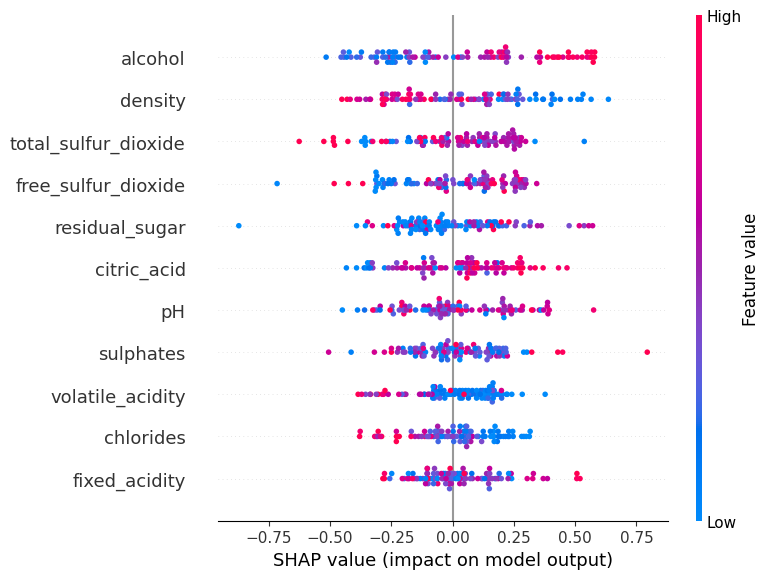

In [73]:
# Import SHAP
import shap

# Select a subset of the test data to reduce computation time
X_test_sample = X_test[:100]  # Adjust the number as needed

# Define the model prediction function
def model_predict(data):
    return best_model.predict(data)

# Use a sample of the training data as background data for SHAP
X_train_sample = X_train[:100]  # Adjust the number as needed

# Initialize the KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_train_sample)

# Compute SHAP values for the test sample
shap_values = explainer.shap_values(X_test_sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_sample, feature_names=X_raw.columns)


In [74]:
# Identify the top N features from the SHAP plot
top_features = ['alcohol', 'volatile_acidity', 'sulphates']  # Replace with your top features

# Create new datasets with only top features
X_train_top = pd.DataFrame(X_train, columns=X_raw.columns)[top_features]
X_val_top = pd.DataFrame(X_val, columns=X_raw.columns)[top_features]
X_test_top = pd.DataFrame(X_test, columns=X_raw.columns)[top_features]

# Retrain the SVM model
best_model.fit(X_train_top, y_train)

# Evaluate the model
y_val_pred = best_model.predict(X_val_top)
print("Validation Classification Report with Top Features:")
print(classification_report(y_val, y_val_pred))

y_test_pred = best_model.predict(X_test_top)
print("Test Classification Report with Top Features:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report with Top Features:
              precision    recall  f1-score   support

           3       0.65      0.86      0.74       425
           4       0.60      0.54      0.57       426
           5       0.48      0.47      0.47       426
           6       0.42      0.21      0.28       425
           7       0.52      0.49      0.50       425
           8       0.61      0.71      0.66       425
           9       0.84      1.00      0.92       426

    accuracy                           0.61      2978
   macro avg       0.59      0.61      0.59      2978
weighted avg       0.59      0.61      0.59      2978

Test Classification Report with Top Features:
              precision    recall  f1-score   support

           3       0.65      0.87      0.75       425
           4       0.54      0.50      0.52       425
           5       0.47      0.47      0.47       425
           6       0.46      0.20      0.28       426
           7       0.53      0.51 

In [57]:
# Outside the loop
for i in range(5):
    # Inside the loop
    print(i)
# Outside the loop again
print("Done")


0
1
2
3
4
Done


In [58]:
# Calculate forgettability score as the proportion of times misclassified
forgettability_df['forgettability_score'] = (
    forgettability_df['misclassified_count'] / forgettability_df['total_count']
)


In [75]:
# View instances with the highest forgettability scores
most_forgettable = forgettability_df.sort_values(by='forgettability_score', ascending=False)
print("Top 10 most forgettable instances:")
print(most_forgettable.head(10))

# View instances that were always correctly classified
unforgettable = forgettability_df[forgettability_df['forgettability_score'] == 0]
print("Number of unforgettable instances:", len(unforgettable))


Top 10 most forgettable instances:
       misclassified_count  total_count  forgettability_score
index                                                        
11827                    1            1                   1.0
4279                     1            1                   1.0
4292                     1            1                   1.0
4291                     1            1                   1.0
4290                     1            1                   1.0
4289                     1            1                   1.0
13602                    1            1                   1.0
4285                     1            1                   1.0
4283                     1            1                   1.0
4281                     1            1                   1.0
Number of unforgettable instances: 14645


In [76]:
from sklearn.model_selection import train_test_split

# Split the resampled dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 13896
Validation set size: 2978
Test set size: 2978


In [77]:
from sklearn.model_selection import train_test_split

# Split the resampled dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 13896
Validation set size: 2978
Test set size: 2978


In [78]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM with RBF kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Validate the model
y_val_pred = svm_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = svm_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.77      0.86      0.81       426
           5       0.62      0.61      0.61       426
           6       0.52      0.31      0.39       425
           7       0.54      0.57      0.56       425
           8       0.69      0.79      0.74       425
           9       1.00      1.00      1.00       426

    accuracy                           0.73      2978
   macro avg       0.72      0.73      0.72      2978
weighted avg       0.72      0.73      0.72      2978

Test Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.76      0.83      0.79       425
           5       0.64      0.62      0.63       425
           6       0.55      0.34      0.42       426
           7       0.57      0.59      0.58       426
           8    

In [63]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()


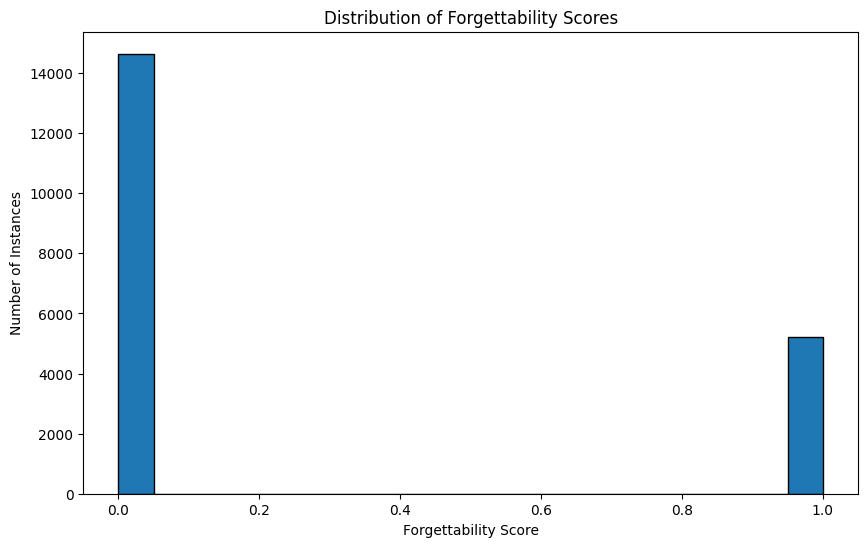

In [79]:
# Merge forgettability scores back with the resampled data
X_resampled_with_scores = X_resampled.copy()
X_resampled_with_scores['forgettability_score'] = forgettability_df['forgettability_score'].values
X_resampled_with_scores['quality'] = y_resampled.values

# Analyze the distribution of forgettability scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(forgettability_df['forgettability_score'], bins=20, edgecolor='k')
plt.title('Distribution of Forgettability Scores')
plt.xlabel('Forgettability Score')
plt.ylabel('Number of Instances')
plt.show()


In [80]:
# Set a threshold for high forgettability
threshold = 0.6  # You can adjust this threshold as needed

# Select instances with high forgettability
forgettable_instances = X_resampled_with_scores[X_resampled_with_scores['forgettability_score'] > threshold]

print("Number of highly forgettable instances:", forgettable_instances.shape[0])

# Describe the forgettable instances
print("Statistical summary of highly forgettable instances:")
print(forgettable_instances.describe())


Number of highly forgettable instances: 5207
Statistical summary of highly forgettable instances:
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    5207.000000       5207.000000  5207.000000     5207.000000   
mean        7.160282          0.330905     0.317463        4.855588   
std         1.238688          0.157893     0.127718        4.215653   
min         4.200000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.260000        1.800000   
50%         6.933843          0.290000     0.310328        2.700000   
75%         7.600000          0.380000     0.380000        7.000000   
max        15.900000          1.330000     0.860000       26.050000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  5207.000000          5207.000000           5207.000000  5207.000000   
mean      0.051564            29.198414            112.708631     0.994045   
std       0.029480          

In [81]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [82]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM with RBF kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Validate the model
y_val_pred = svm_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.77      0.86      0.81       426
           5       0.62      0.61      0.61       426
           6       0.52      0.31      0.39       425
           7       0.54      0.57      0.56       425
           8       0.69      0.79      0.74       425
           9       1.00      1.00      1.00       426

    accuracy                           0.73      2978
   macro avg       0.72      0.73      0.72      2978
weighted avg       0.72      0.73      0.72      2978



In [83]:
# Test the model
y_test_pred = svm_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.76      0.83      0.79       425
           5       0.64      0.62      0.63       425
           6       0.55      0.34      0.42       426
           7       0.57      0.59      0.58       426
           8       0.71      0.86      0.78       426
           9       1.00      1.00      1.00       425

    accuracy                           0.75      2978
   macro avg       0.74      0.75      0.74      2978
weighted avg       0.74      0.75      0.74      2978



In [84]:
full_data.info()
# Splitting dataset into train (70%), validation (15%), and test (15%)
X = full_data.drop('quality', axis=1)  # Features
y = full_data['quality']  # Target

# First, split train and temp (train=70%, temp=30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test (50% each of the temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


NameError: name 'full_data' is not defined

In [70]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 13896
Validation set size: 2978
Test set size: 2978


In [71]:
print("Training class distribution:")
print(y_train.iloc[:, 0].value_counts())

print("Validation class distribution:")
print(y_val.iloc[:, 0].value_counts())

print("Test class distribution:")
print(y_test.iloc[:, 0].value_counts())



Training class distribution:


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [85]:
from sklearn.metrics import classification_report

# Validate the model
y_val_pred = svm_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = svm_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.77      0.86      0.81       426
           5       0.62      0.61      0.61       426
           6       0.52      0.31      0.39       425
           7       0.54      0.57      0.56       425
           8       0.69      0.79      0.74       425
           9       1.00      1.00      1.00       426

    accuracy                           0.73      2978
   macro avg       0.72      0.73      0.72      2978
weighted avg       0.72      0.73      0.72      2978

Test Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.99      0.96       425
           4       0.76      0.83      0.79       425
           5       0.64      0.62      0.63       425
           6       0.55      0.34      0.42       426
           7       0.57      0.59      0.58       426
           8    

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

# Perform Grid Search
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, scoring='accuracy')
grid.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid.best_params_)

# Evaluate with the best model
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Test Classification Report with Best Model:")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.9s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Test Classification Report with Best Model:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       425
           4       0.95      0.99      0.97       425
           5       0.81      0.72      0.76       425
           6       0.68      0.73      0.70       426
           7       0.89      0.88      0.89       426
           8       0.98      1.00      0.99       426
           9       1.00      1.00      1.00       425

    accuracy                           0.90      2978
   macro avg       0.90      0.90      0.90      2978
weighted avg       0.90      0.90      0.90      2978



In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(svm_model, X_test, y_test, scoring='accuracy')

# Print feature importance
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"Feature {i}: {perm_importance.importances_mean[i]:.4f}")


Feature 10: 0.2564
Feature 7: 0.1833
Feature 0: 0.1818
Feature 8: 0.1650
Feature 6: 0.1592
Feature 5: 0.1482
Feature 1: 0.1420
Feature 3: 0.1384
Feature 4: 0.1367
Feature 2: 0.1343
Feature 9: 0.1204


In [ ]:
pip install shap


In [ ]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(svm_model.predict, X_test)
shap_values = explainer(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)


PermutationExplainer explainer:   6%|▋         | 192/2978 [1:50:17<26:48:46, 34.65s/it]


KeyboardInterrupt: 

In [ ]:
# Check if there are duplicates
full_data.duplicated().sum()
# Splitting dataset into train (70%), validation (15%), and test (15%)
X = full_data.drop('quality', axis=1)  # Features
y = full_data['quality']  # Target

# First, split train and temp (train=70%, temp=30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test (50% each of the temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


1179

In [ ]:
full_data.drop_duplicates(inplace=True)
# Splitting dataset into train (70%), validation (15%), and test (15%)
X = full_data.drop('quality', axis=1)  # Features
y = full_data['quality']  # Target

# First, split train and temp (train=70%, temp=30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test (50% each of the temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


In [86]:
full_data.shape
# Splitting dataset into train (70%), validation (15%), and test (15%)
X = full_data.drop('quality', axis=1)  # Features
y = full_data['quality']  # Target

# First, split train and temp (train=70%, temp=30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test (50% each of the temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


NameError: name 'full_data' is not defined

# 2.0 Dataset Preprocessing

We are splitting the dataset into 3 sets, including:

- Validation: 15% (model never seen it);
- Test: 15%;
- Train: 70%.

In [ ]:
# Randomly take 15% of the dataset as validation set, seeding: 27
validation_data = full_data.sample(frac=0.15, random_state=27)
train_test_data = full_data.drop(validation_data.index)
# Splitting dataset into train (70%), validation (15%), and test (15%)
X = full_data.drop('quality', axis=1)  # Features
y = full_data['quality']  # Target

# First, split train and temp (train=70%, temp=30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test (50% each of the temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


In [ ]:
X_val = validation_data.drop('quality', axis=1)
y_val = validation_data['quality']

In [ ]:
# Take the dataset's quality column as y, the rest as X
y = train_test_data['quality']
X = train_test_data.drop('quality', axis=1)

print(f'Feature train_test shape: {X.shape}')
print(f'Label train_test shape: {y.shape}')

Feature train_test shape: (4520, 11)
Label train_test shape: (4520,)


In [ ]:
from sklearn.model_selection import train_test_split
# Train test split of the data using train_test_split function, with a ratio of 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27, test_size=0.3)

----------

Please start from here:

As coded above, X_val y_val are validation set. Please do not use it until the end when validate the model to check the accuracy.

For training, X_train, X_test, y_train, y_test are defined for model training.

Before next meeting on Saturday:

1. Zhanyang: ResNet
2. Dylan: Neural Networks, logistic regression
3. Eric: JTT
4. Reza: SVM

Everyone:

Look for libraries for
**Forgettability Score**
to finding instances that is unforgettable and forgettable.





In [1]:
# Assuming X_resampled and y_resampled are your features and targets after SMOTE

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [2]:
# Create a DataFrame to track misclassifications
forgettability_df = pd.DataFrame({
    'index': X_resampled.index,
    'misclassified_count': 0,
    'total_count': 0
})
forgettability_df.set_index('index', inplace=True)


NameError: name 'X_resampled' is not defined

#3.0 Modeling

In [ ]:
import sklearn
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
import shap
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

PermutationExplainer explainer: 6498it [09:05, 11.73it/s]


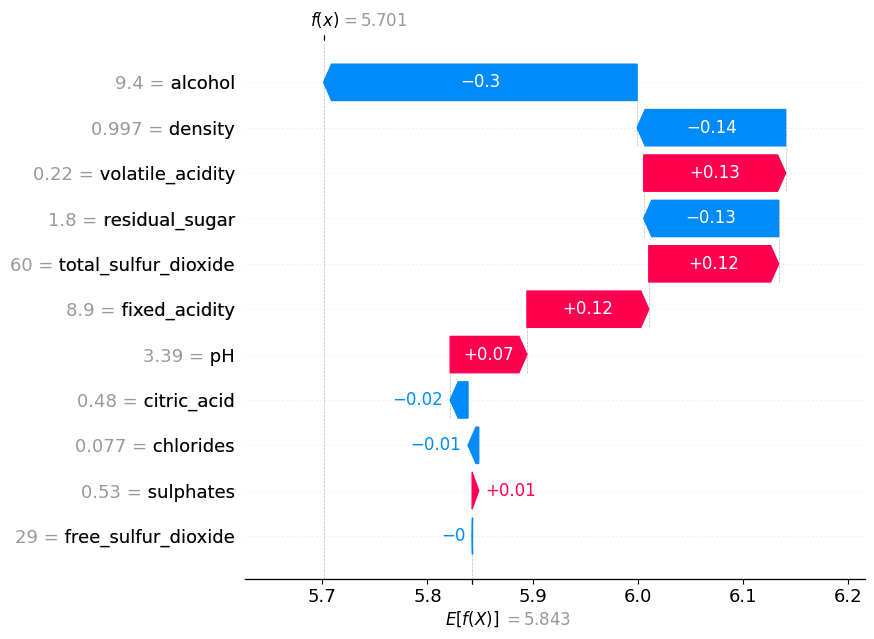

In [ ]:
shap.plots.waterfall(shap_values[20], max_display=14)

In [ ]:
y.iloc[20]

,20
quality,6
